# Gradients through iLQR

## Imports

In [1]:
import jax
from jax import Array
import jax.random as jr
import jax.numpy as jnp
from matplotlib import pyplot as plt
from diffilqrax.diff_ilqr import dilqr
from diffilqrax.ilqr import ilqr_solver
from diffilqrax.exact import quad_solve, exact_solve
from diffilqrax.utils import keygen
from diffilqrax.typs import (
    iLQRParams,
    System,
    ModelDims,
    Thetax0,
    Theta,
)

jax.config.update("jax_default_device", jax.devices("cpu")[0])
jax.config.update("jax_enable_x64", True)  # double precision


## iLQR Optimisation Problem

The Iterative Linear Quadratic Regulator (iLQR) is an optimization algorithm used for trajectory optimization in control systems. It iteratively refines a control policy to minimize a cost function over a finite time horizon.

### Problem Formulation

Given a dynamical system described by the state equation:
$$ x_{t+1} = f(x_t, u_t) $$
where  $x_t$ is the state at time $t$ and $u_t$ is the control input at time $ t $.

The objective is to find a sequence of control inputs $ \{u_0, u_1, \ldots, u_{T-1}\} $ that minimizes the cost function:
$$ J = \ell_{T}(x_T) + \sum_{t=0}^{T-1} \ell(x_t, u_t) $$
where $ \ell_{T}(x_T) $ is the terminal cost and $ \ell(x_t, u_t) $ is the running cost.

### Linear Quadratic Approximation

iLQR approximates the nonlinear dynamics and cost function using a quadratic expansion around a nominal trajectory $ \{x_t^0, u_t^0\} $:

1. **Dynamics Linearization:**
    $$ x_{t+1} \approx A_t x_t + B_t u_t + c_t $$
    where $ A_t = \frac{\partial f}{\partial x} \bigg|_{(x_t^0, u_t^0)} $, $ B_t = \frac{\partial f}{\partial u} \bigg|_{(x_t^0, u_t^0)} $, and $ c_t = f(x_t^0, u_t^0) - A_t x_t^0 - B_t u_t^0 $.

2. **Cost Quadratic Approximation:**
    $$ \ell(x_t, u_t) \approx \frac{1}{2} \begin{bmatrix} x_t \\ u_t \end{bmatrix}^T \begin{bmatrix} Q_t & S_t \\ S_t^T & R_t \end{bmatrix} \begin{bmatrix} x_t \\ u_t \end{bmatrix} + \begin{bmatrix} q_t \\ r_t \end{bmatrix}^T \begin{bmatrix} x_t \\ u_t \end{bmatrix} + l_t $$
    where $ Q_t, S_t, R_t, q_t, r_t, l_t $ are the coefficients of the quadratic expansion.

### Backward Pass

In the backward pass, the value function is approximated by a quadratic function:
$$ V_t(x_t) \approx \frac{1}{2} x_t^T P_t x_t + p_t^T x_t + \alpha_t $$

The optimal control law is derived as:
$$ \delta u_t = -K_t \delta x_t - k_t $$
where $ K_t $ and $ k_t $ are the feedback and feedforward gains, respectively.

### Forward Pass

In the forward pass, the control inputs are updated using the derived control law, and the state trajectory is propagated using the system dynamics.

### Iteration

The process of linearization, backward pass, and forward pass is repeated until convergence.

This iterative process refines the control policy and trajectory, leading to an optimal solution for the given cost function and system dynamics.


## Set-up problem

### Implementation

The iLQR `System` contains the dimensionality of the problem in `ModelDims`, the non-linear dynamics, cost, and terminal cost functions.

In [2]:
# Set-up dimensionality
dims = ModelDims(horizon=100, n=10, m=2, dt=0.1)

# Set-up prarameters
key = jr.PRNGKey(seed=0)
key, skeys = keygen(key, 4)
Uh = jax.random.normal(next(skeys), (dims.n, dims.n)) * 0.5 / jnp.sqrt(dims.n)

Wh =  jax.random.normal(next(skeys), (dims.n, dims.m)) * 0.5 / jnp.sqrt(dims.n) * dims.dt
L = jax.random.normal(next(skeys), (dims.n, dims.n)) * 0.5 / jnp.sqrt(dims.n)
Q = L @ L.T

# Build system parameters
theta = Theta(Uh=Uh, Wh=Wh, Q=Q, sigma=jnp.zeros(dims.n, dtype=jnp.float64))
params = iLQRParams(x0=jnp.zeros(dims.n, dtype=jnp.float64), theta=theta)

In [3]:
# Define iLQR model
def cost(t: int, x: Array, u: Array, theta: Theta):
    x_tgt = jnp.sin(t/5)
    return (
        jnp.sum(
            (x.squeeze() - x_tgt.squeeze())
            @ theta.Q @ 
            (x.squeeze() - x_tgt.squeeze()).T
        )
        + jnp.sum(u**2)
    )

def costf(x: Array, theta: Theta):
    # return jnp.sum(jnp.abs(x))
    return jnp.sum(x**2)

def dynamics(t: int, x: Array, u: Array, theta: Theta):
    return (theta.Uh @ jnp.tanh(x)) + theta.Wh @ jnp.tanh(u) + jnp.sum(theta.Uh)*jnp.ones_like(x)

ilqr_model = System(
    cost, costf, dynamics, dims
)

# Initialise u sequence
Us_init = 0. * jr.normal(
            next(skeys), (dims.horizon, dims.m)
        )

## Solve iLQR

Define linesearch hyperparameters

In [4]:
ls_kwargs = {
            "beta": 0.5,
            "max_iter_linesearch": 24,
            "tol": 0.01,
            "alpha_min": 0.00001,
        }

In [5]:
opt_traj = dilqr(
    ilqr_model,
    params,
    Us_init,
    max_iter=70,
    convergence_thresh=1e-9,
    alpha_init=1.,
    use_linesearch=True,
    # verbose=True,
    **ls_kwargs
    )

In [6]:
opt_state, opt_input = opt_traj[:, :dims.n], opt_traj[:-1, dims.n:]

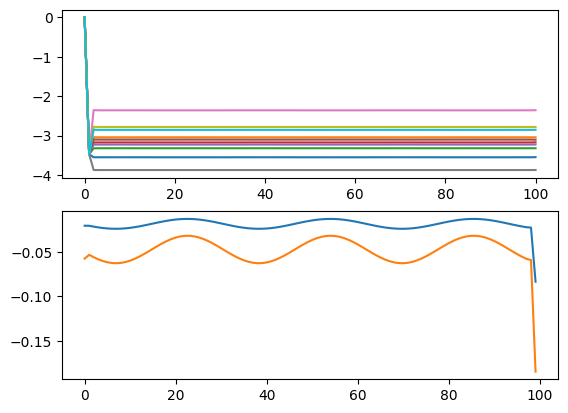

In [7]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(opt_state)
axes[1].plot(opt_input)

In [8]:
(opt_state_ilqr, opt_input_ilqr, opt_costate_ilqr), J0, cost_log = ilqr_solver(
    ilqr_model,
    params,
    Us_init,
    max_iter=70,
    convergence_thresh=1e-9,
    alpha_init=1.,
    use_linesearch=True,
    # verbose=True,
    **ls_kwargs
    )

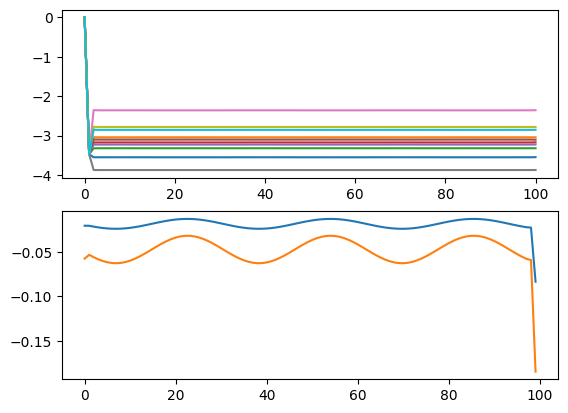

In [9]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(opt_state_ilqr)
axes[1].plot(opt_input_ilqr)

## iLQR Gradient

> TODO: Explain the difference in the two gradients from ilqr solver and dilqr solver

Implicitly differentiate through the iLQR solver using custom `jax.jvp` function

In [10]:
def implicit_loss(theta_params):
    theta = Theta(Q=theta_params.theta.Q, Uh=theta_params.theta.Uh, Wh=theta_params.theta.Wh, sigma=jnp.zeros((dims.n), dtype=jnp.float64))
    params = iLQRParams(x0=0.*theta_params.x0, theta=theta)
    tau_star = dilqr(
        ilqr_model,
        params,
        Us_init,
        max_iter=70,
        convergence_thresh=1e-9,
        alpha_init=1.0,
        use_linesearch=True,
        **ls_kwargs,
    )
    opt_xs = tau_star[:, : dims.n]
    opt_us = tau_star[:, dims.n :]
    return jnp.linalg.norm(opt_xs) ** 2 + jnp.linalg.norm(opt_us) ** 2

In [11]:
def direct_loss(prms):
    theta = Theta(Uh=prms.theta.Uh, Wh=prms.theta.Wh, Q=prms.theta.Q, sigma=jnp.zeros((dims.n), dtype=jnp.float64))
    params = iLQRParams(x0=0.*prms.x0, theta=theta)
    (opt_xs, opt_us, _), _, _ = ilqr_solver(
        ilqr_model,
        params,
        Us_init,
        max_iter=70,
        convergence_thresh=1e-8,
        alpha_init=1.0,
        use_linesearch=True,
        **ls_kwargs,
    )

    return jnp.linalg.norm(opt_xs) ** 2 + jnp.linalg.norm(opt_us) ** 2

In [12]:
implicit_val, implicit_g = jax.value_and_grad(implicit_loss)(params)
direct_val, direct_g = jax.value_and_grad(direct_loss)(params)

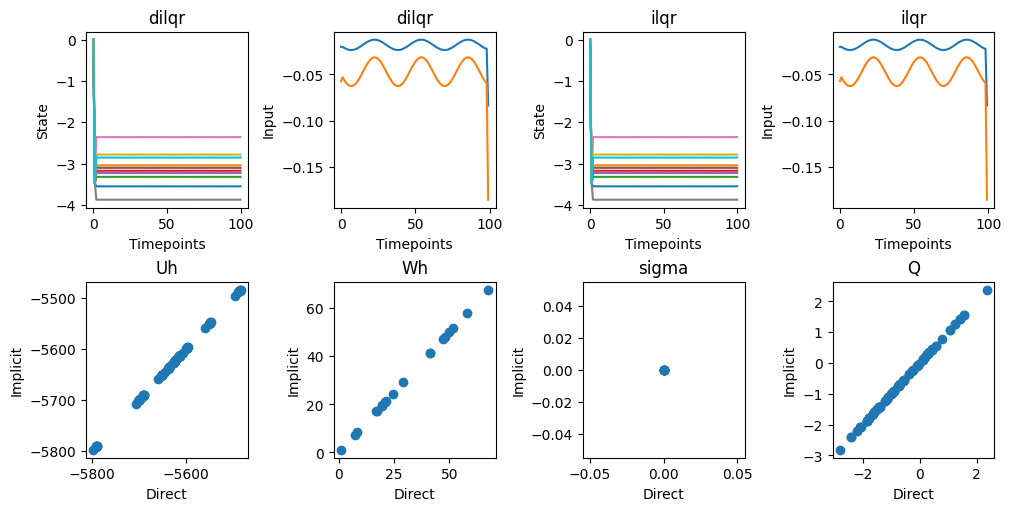

In [13]:
fig, axes = plt.subplots(2,len(direct_g.theta), figsize=(10, 5), layout="constrained")
for (ax, dg, ig, n) in zip(axes.flatten()[-4:], direct_g.theta, implicit_g.theta, implicit_g.theta._fields):
    ax.scatter(dg.flatten(), ig.flatten())
    ax.set(xlabel="Direct", ylabel="Implicit", title=f"{n}")
for (ax, opt_v, ax_title, y_lab) in zip(axes.flatten()[:4], (opt_state, opt_input, opt_state_ilqr, opt_input_ilqr), ("dilqr", "dilqr", "ilqr", "ilqr"), ("State", "Input", "State", "Input")):
    ax.plot(opt_v)
    ax.set(xlabel="Timepoints", ylabel=y_lab, title=ax_title)

# fig.tight_layout()